In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams.update({'font.size': 20})
import pandas as pd
from virgodb import VirgoDB
vdb = VirgoDB("giorgio",password="BN401kmd")
import time

from fase.fileio import Table

# COSMOLOGY

In [4]:
def integ_trap(func,z1,z2,N=1000):
    z = np.logspace(np.log10(z1),np.log10(z2),N)
    y = func(z)

    A = 0
    for i in range(len(z)-1):
        A += np.abs((z[i+1]-z[i]))*(y[i]+y[i+1])/2
    return A

def E(z,Om_rad=8.4*10**(-5),Om_lambda=0.7,Om_mat=0.3):
    return np.sqrt(Om_rad*(1+z)**4 + Om_mat*(1+z)**3 + Om_lambda)

def over_E(z):
    return E(z)**(-1)

def comoving_distance(z):
    zero = 10**(-20)
    c = 3e5 #km/s
    H0=100. #km/s/Mpc
    return (c*H0**(-1)*integ_trap(over_E,zero,z,10**(3))) #Mpc h^-1

vec_r = np.vectorize(comoving_distance)

def Luminosity_distance(z):
    '''Returns the Luminosity distance in units of Mpc h^-1'''
    return comoving_distance(z)*(1.+z)

def ABSOLUTE_MAGNITUDE_minus5logh(m,z,K_correction=False,ratio_L=1.):
    if K_correction:
        return m -25. -5.*np.log10(Luminosity_distance(z)) -2.5*np.log10(ratio_L*(1.+z))
    else:
        return m -25. -5.*np.log10(Luminosity_distance(z))

vec_ABSOLUTE_MAGNITUDE_minus5logh = np.vectorize(ABSOLUTE_MAGNITUDE_minus5logh)

# EDGE

In [5]:
def EDGE(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_bin_size=0.15,threashold =0.15):
    '''It returns two arrays containing the x and y of the edge'''
    y_Nbins = int((y_max - y_min) / y_bin_size)
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    #loop on y bins
    for i in range(y_Nbins):
        # define y bin
        y_low = y_min + y_bin_size * i
        y_high = y_min + y_bin_size * (i+1)
        y_center = (y_low+y_high)/2.
        select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        # histogram of x in a selected y bin
        x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        #find most populated bin
        x_histo_max = np.max(x_histo[:-1])
        x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        for j in range(x_histo_max_index,0,-1):
            if (x_histo[j]<x_histo_max * threashold):
                edge_index = j
                break
        x_edge.append(x_histo_bins[j])
        y_edge.append(y_center)
    return np.array(x_edge), np.array(y_edge)

# QUERY

In [6]:
QJ = 'SELECT '
QJ += '   des.mag_V_ext as d_mag_V_ext, '
QJ += '   des.SDSS_u_ext as d_SDSS_u_ext, '
QJ += '   prog.mag_V_ext as p_mag_V_ext, '
QJ += '   prog.SDSS_u_ext as p_SDSS_u_ext, ' 
QJ += '   prog.stellarmass as p_stellarmass, '
QJ += '   des.stellarmass as d_stellarmass, '
QJ += '   des.SDSS_i_obs_ext as d_SDSS_i_obs_ext, '
QJ += '   prog.SDSS_i_obs_ext as p_SDSS_i_obs_ext '
QJ += 'FROM '
QJ += '   Gonzalez2014a..mr7 as des with(index(pk_mr7_galaxyid)), '
QJ += '   Gonzalez2014a..mr7 as prog with(forceseek,index(pk_mr7_galaxyid)) '
QJ += 'WHERE '
QJ += '   des.snapnum = 47 AND '
QJ += '   prog.galaxyid BETWEEN des.galaxyid AND des.mainleafid '
QJ += '   AND prog.snapnum = 37 '
QJ += '   AND des.stellarmass>0.1 '

t1 = time.time()
vdb.query_to_file("../data/prog_37_47_JohnHelly_0.txt", QJ, format="text")
t2 = time.time()

1399.34540987


In [11]:
print "Query time = ",(t2-t1)/60,"minutes"

Query time =  23.3224234978 minutes


# Read from file

In [6]:
john_0 = pd.read_csv("../data/prog_37_47_JohnHelly_0.txt",comment='#',delimiter=',')

In [7]:
print 'Names  :', john_0.columns.values
print 'Length :',len(john_0)

Names  : ['d_mag_V_ext' 'd_SDSS_u_ext' 'p_mag_V_ext' 'p_SDSS_u_ext' 'p_stellarmass'
 'd_stellarmass' 'd_SDSS_i_obs_ext' 'p_SDSS_i_obs_ext']
Length : 3857651


# COLOUR MAGNITUDE

## GALFORM Variables

In [8]:
#cut of the descendants (z~0.46) at i<22.5 
CUT_225_d = np.where(john_0['d_SDSS_i_obs_ext']<ABSOLUTE_MAGNITUDE_minus5logh(22.5,0.46))
#cut of the progenitors (z~1.17) at i<22.5 
CUT_225_p = np.where(john_0['p_SDSS_i_obs_ext']<ABSOLUTE_MAGNITUDE_minus5logh(22.5,1.17))

print "ABSOLUTE MAGNITUDE OF m=22.5 at z ~ 0.46: ",round((ABSOLUTE_MAGNITUDE_minus5logh(22.5,0.46)),2)
print "ABSOLUTE MAGNITUDE OF m=22.5 at z ~ 1.17: ",round((ABSOLUTE_MAGNITUDE_minus5logh(22.5,1.17)),2)

xp = np.array(john_0['p_mag_V_ext'])[CUT_225_p]
yp = np.array(john_0['p_SDSS_u_ext'])[CUT_225_p]-np.array(john_0['p_mag_V_ext'])[CUT_225_p]

xd = np.array(john_0['d_mag_V_ext'])[CUT_225_d]
yd = np.array(john_0['d_SDSS_u_ext'])[CUT_225_d]-np.array(john_0['d_mag_V_ext'])[CUT_225_d]


ABSOLUTE MAGNITUDE OF m=22.5 at z ~ 0.46:  -18.77
ABSOLUTE MAGNITUDE OF m=22.5 at z ~ 1.17:  -21.25


In [9]:
john_0['p_SDSS_i_obs_ext']

0         -16.863281
1         -17.147202
2         -18.190075
3         -18.419014
4         -16.566809
5         -17.408678
6         -17.871126
7         -17.900503
8         -17.632784
9         -17.247221
10        -16.804790
11        -16.910470
12        -17.261013
13        -16.620676
14        -18.287830
15        -17.955948
16        -17.790283
17        -18.557606
18        -17.731956
19        -19.027304
20        -19.167969
21        -18.421825
22        -20.376692
23        -16.835896
24        -18.882153
25        -17.436977
26        -18.021969
27        -17.598532
28        -17.731224
29        -18.011896
             ...    
3857621   -17.328571
3857622   -17.375070
3857623   -15.602664
3857624   -17.419876
3857625   -17.170446
3857626   -17.358252
3857627   -17.525867
3857628   -17.172983
3857629   -17.752556
3857630   -17.315886
3857631   -17.501623
3857632   -17.279076
3857633   -17.598475
3857634   -17.214878
3857635   -17.843811
3857636   -18.057606
3857637   -17

## Define the edge

In [10]:
xd_edge,yd_edge = EDGE(xd,yd,y_min=0.,y_max=2.2,y_bin_size=0.06,threashold=0.15)
xp_edge,yp_edge = EDGE(xp,yp,y_min=0.,y_max=2.2,y_bin_size=0.06,threashold=0.15)

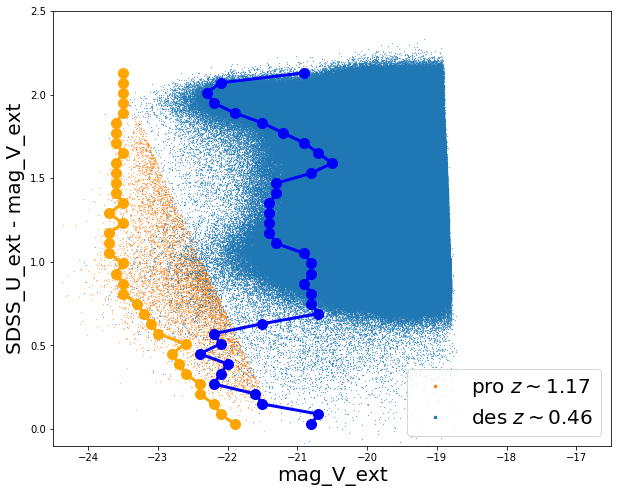

In [11]:
plt.figure(figsize=(10,8))

#points
plt.plot(xp,yp,".",markersize=0.5,label=r'pro $z\sim1.17$',c='C1')
plt.plot(xd,yd,".",markersize=0.5,label=r'des $z\sim0.46$',c='C0')

#edges
plt.plot(xp_edge,yp_edge,".",markersize=20,c='orange')
plt.plot(xp_edge,yp_edge,"-",lw=3,c='orange')
plt.plot(xd_edge,yd_edge,".",markersize=20,c='blue')
plt.plot(xd_edge,yd_edge,"-",lw=3,c='blue')

#labels
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=10)

#limits
plt.xlim(-24.5,-16.5)
plt.ylim(-0.1,2.5)

#plt.savefig("../plots/009/col_mag_des_prog_cut225_edge_002thr.png")
plt.show()

# Plot histograms of magnitudes per colour bin

In [66]:
def HISTO(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_bin_size=0.15,threashold =0.15,save=True):

    plt.figure(figsize=(10,8))
    
    y_Nbins = int((y_max - y_min) / y_bin_size)
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    #loop on y bins
    for i in range(y_Nbins):
        # define y bin
        y_low = y_min + y_bin_size * i
        y_high = y_min + y_bin_size * (i+1)
        y_center = (y_low+y_high)/2.
        select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        # histogram of x in a selected y bin
        #x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        plt.hist(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max),histtype='bar',lw=3)
        if save:
            plt.savefig('../plots/009/histo/'+str(int(y_center*100))+".png")
    plt.ylabel("counts")
    plt.xlabel("mag_V_ext")
    plt.savefig('../plots/009/histo_mags_per_colour.png')
    plt.show()
        #find most populated bin
        #x_histo_max = np.max(x_histo[:-1])
        #x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        #for j in range(x_histo_max_index,0,-1):
        #    if (x_histo[j]<x_histo_max * threashold):
        #        edge_index = j
        #        break
        #x_edge.append(x_histo_bins[j])
        #y_edge.append(y_center)
    #return np.array(x_edge), np.array(y_edge)

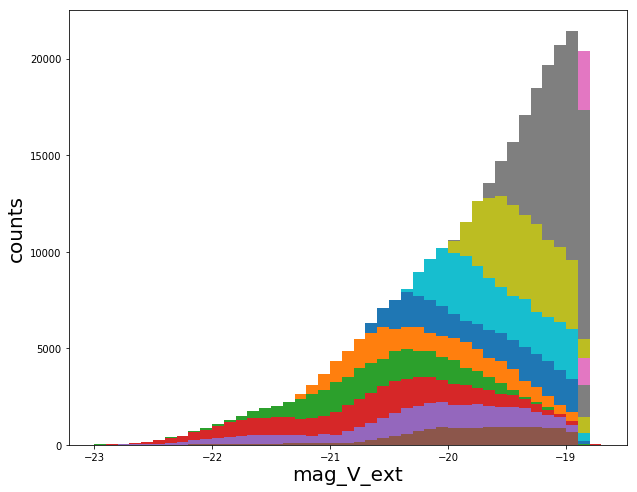

In [67]:
HISTO(xd,yd,y_min=0.,y_max=2.2,y_bin_size=0.06,x_min=-23.,x_max=-18.7)

# Draw contours

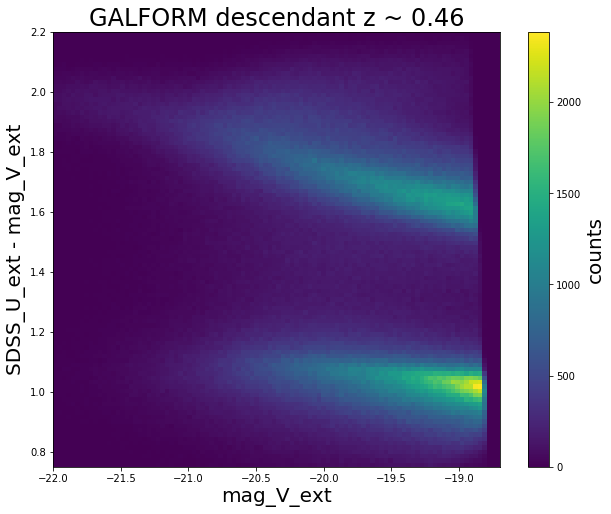

In [227]:
plt.figure(figsize=(10,8))
plt.hist2d(xd,yd,bins=100,range=[[-22,-18.7],[0.75,2.2]])
plt.colorbar(label='counts')
plt.title('GALFORM descendant z ~ 0.46')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.savefig("../plots/009/histo2d_galform_low_z.png")
plt.show()

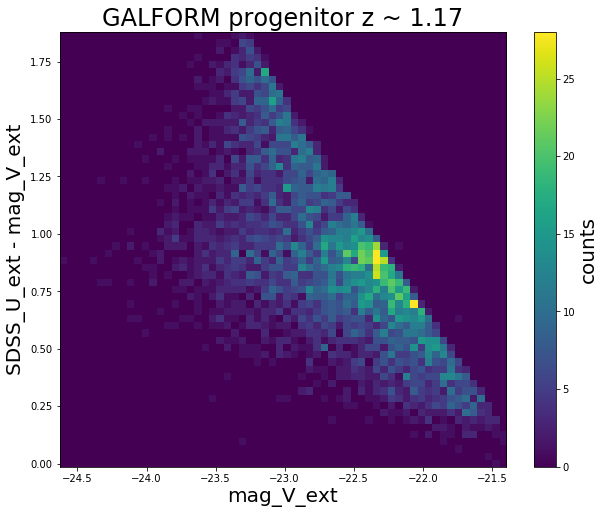

In [228]:
plt.figure(figsize=(10,8))
plt.hist2d(xp,yp,bins=60)#,range=[[-22,-18.7],[0.75,2.2]])
plt.colorbar(label='counts')
plt.title('GALFORM progenitor z ~ 1.17')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.savefig("../plots/009/histo2d_galform_high_z.png")
plt.show()

In [207]:
counts_des,x_edges_des,y_edges_des = np.histogram2d(xd,yd,bins=100,range=[[-22,-18.7],[0.75,2.2]])

In [208]:
X_des,Y_des = np.meshgrid(x_edges_des[:-1],y_edges_des[:-1]) 
# Actually it works also without meshgrid but this is the right thing to do

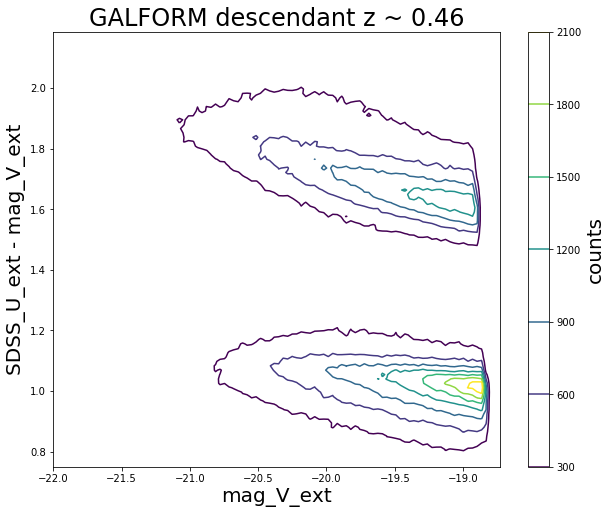

In [233]:
plt.figure(figsize=(10,8))
plt.contour(X_des,Y_des,counts_des.T) # Remember to transpose!!!!!!!!!!! 
#plt.contour(x_edges[:-1],y_edges[:-1],counts.T)
plt.title('GALFORM descendant z ~ 0.46')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.colorbar(label='counts')
plt.savefig("../plots/009/contours_galform_low_z.png")
plt.show()

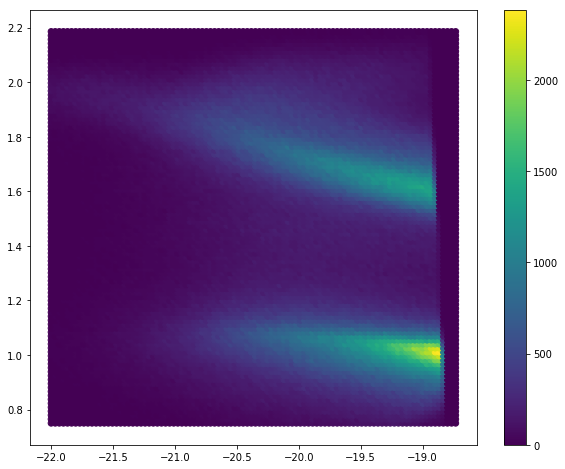

In [210]:
#This plot is not needed but it just show how the np.histogram2d do the same of plt.hist2d
plt.figure(figsize=(10,8))
plt.scatter(X_des,Y_des,c=counts_des.T) # Remember to transpose the output of histo2d (counts)!!!!
plt.colorbar()
plt.show()

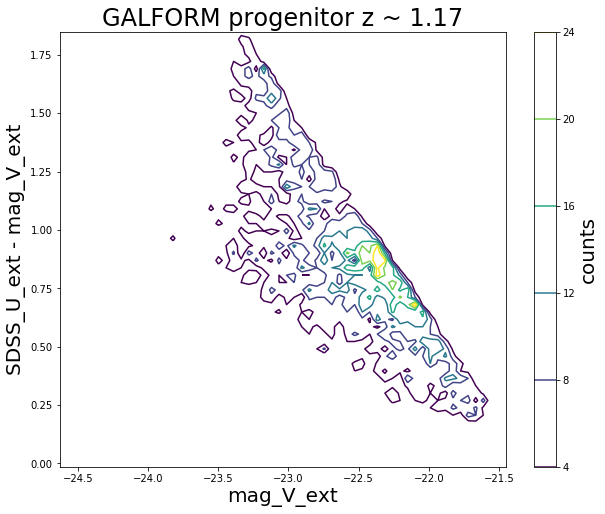

In [234]:
counts_pro,x_edges_pro,y_edges_pro = np.histogram2d(xp,yp,bins=60)
X_pro,Y_pro = np.meshgrid(x_edges_pro[:-1],y_edges_pro[:-1]) 
plt.figure(figsize=(10,8))
plt.contour(X_pro,Y_pro,counts_pro.T) # Remember to transpose!!!!!!!!!!! 
#plt.contour(x_edges[:-1],y_edges[:-1],counts.T)
plt.title('GALFORM progenitor z ~ 1.17')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.colorbar(label='counts')
plt.savefig("../plots/009/contours_galform_high_z.png")
plt.show()

# Read VIPERS

In [13]:
VIPERS = Table("../../Data_Sample_V7.fits",hdu=8)

In [14]:
U_vip = VIPERS.getCol("M_Uj")
V_vip = VIPERS.getCol("M_V")
UV_vip =U_vip-V_vip

z_vip = VIPERS.getCol("zspec_1")

z_low_vip= np.where((z_vip>=0.4)&(z_vip<0.5))
z_hig_vip= np.where((z_vip>=1.0)&(z_vip<1.3))

xedge_vip_zlow,yedge_vip_zlow= EDGE(V_vip[z_low_vip],UV_vip[z_low_vip],x_min=-25,x_max=-18,y_min=0.2,y_max=2.4)
xedge_vip_zhigh,yedge_vip_zhigh= EDGE(V_vip[z_hig_vip],UV_vip[z_hig_vip],x_min=-25,x_max=-18,y_min=0.2,y_max=2.4)

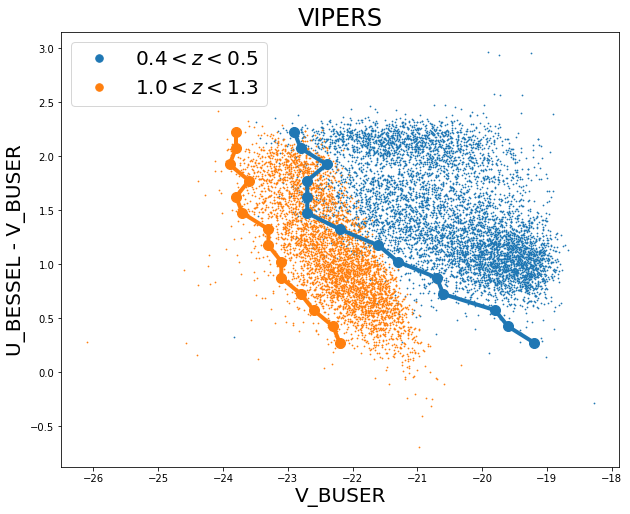

In [15]:
plt.figure(figsize=(10,8))
plt.plot(V_vip[z_low_vip],UV_vip[z_low_vip],".",markersize=1.5,color='C0',label=r'$0.4<z<0.5$')
plt.plot(V_vip[z_hig_vip],UV_vip[z_hig_vip],".",markersize=1.5,color='C1',label=r'$1.0<z<1.3$')
plt.plot(xedge_vip_zlow,yedge_vip_zlow,"-",lw=4,color='C0')
plt.plot(xedge_vip_zhigh,yedge_vip_zhigh,"-",lw=4,color='C1')
plt.plot(xedge_vip_zlow,yedge_vip_zlow,".",lw=4,color='C0',markersize=20)
plt.plot(xedge_vip_zhigh,yedge_vip_zhigh,".",lw=4,color='C1',markersize=20)
plt.legend(markerscale=10)
plt.xlabel("V_BUSER")
plt.ylabel("U_BESSEL - V_BUSER")
plt.title('VIPERS')
#plt.savefig('../plots/008/bright_edge_VIPERS.png')
plt.show()

# Save VIPERS U V magnitudes for plots in COSMA

In [21]:
np.savetxt('../data/vipers_uv.txt',np.array([U_vip,V_vip,z_vip]).T,header='U V z',delimiter=' ',encoding='utf-8')

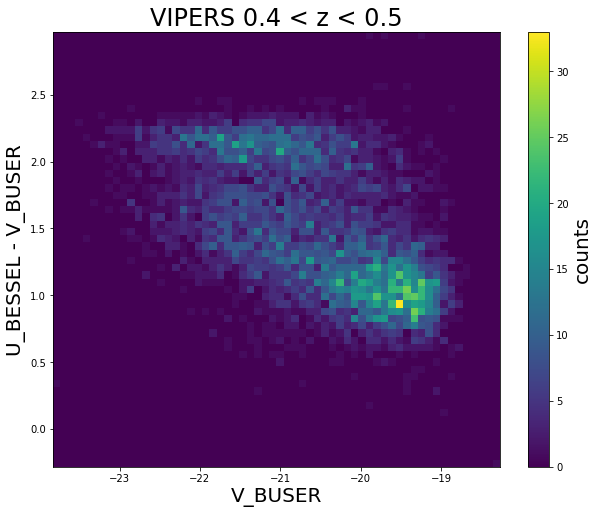

In [241]:
plt.figure(figsize=(10,8))
plt.hist2d(V_vip[z_low_vip],UV_vip[z_low_vip],bins=60)
plt.xlabel("V_BUSER")
plt.ylabel("U_BESSEL - V_BUSER")
plt.title("VIPERS 0.4 < z < 0.5")
plt.colorbar(label='counts')
plt.savefig("../plots/009/histo2d_vipers_LOW_z.png")
plt.show()

In [186]:
counts_vip_zl,x_edges_vip_zl,y_edges_vip_zl =np.histogram2d(V_vip[z_low_vip],UV_vip[z_low_vip],bins=60)

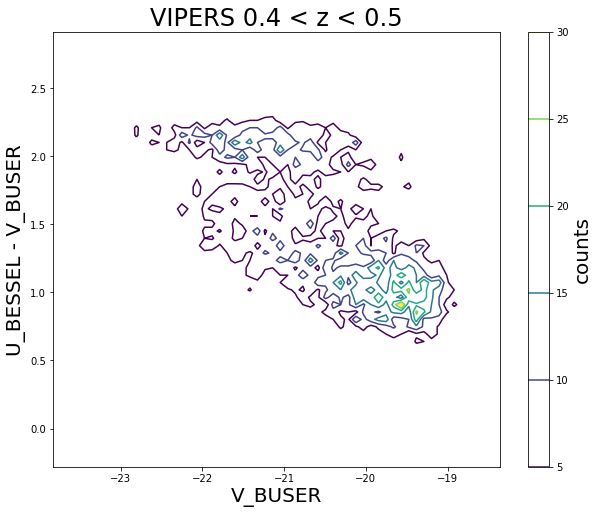

In [239]:
plt.figure(figsize=(10,8))
plt.contour(x_edges_vip_zl[:-1],y_edges_vip_zl[:-1],counts_vip_zl.T)
plt.colorbar(label='counts')
plt.xlabel("V_BUSER")
plt.ylabel("U_BESSEL - V_BUSER")
plt.title("VIPERS 0.4 < z < 0.5")
plt.savefig("../plots/009/CONTOURS_vipers_LOW_z.png")
plt.show()

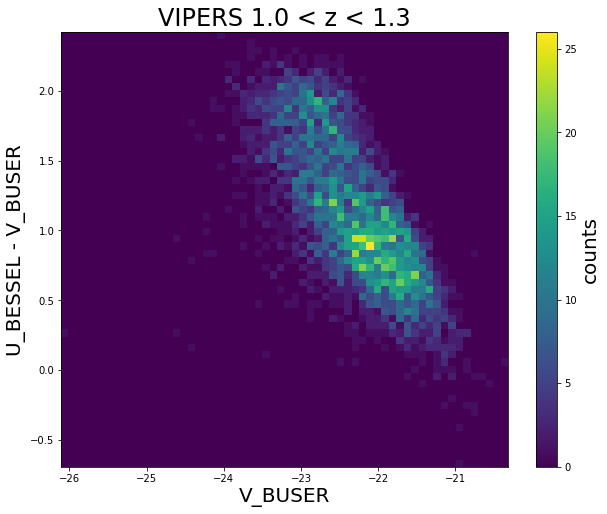

In [21]:
plt.figure(figsize=(10,8))
plt.hist2d(V_vip[z_hig_vip],UV_vip[z_hig_vip],bins=60)
counts_vip_zh,x_edges_vip_zh,y_edges_vip_zh =np.histogram2d(V_vip[z_hig_vip],UV_vip[z_hig_vip],bins=60)
plt.xlabel("V_BUSER")
plt.ylabel("U_BESSEL - V_BUSER")
plt.title("VIPERS 1.0 < z < 1.3")
plt.colorbar(label='counts')
plt.savefig("../plots/009/histo2d_vipers_high_z.png")
plt.show()

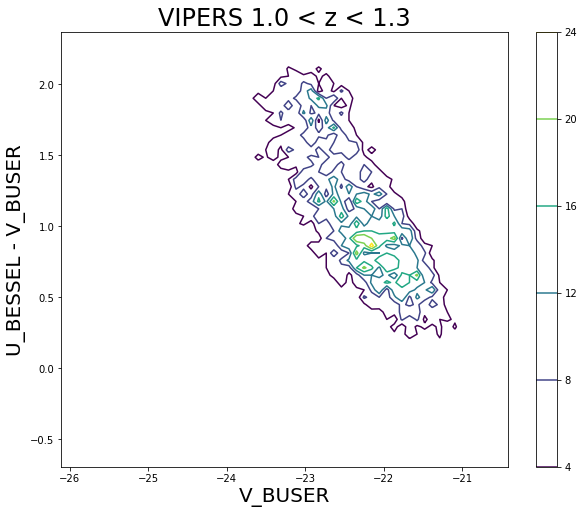

In [242]:
plt.figure(figsize=(10,8))
plt.contour(x_edges_vip_zh[:-1],y_edges_vip_zh[:-1],counts_vip_zh.T)
plt.colorbar()
plt.xlabel("V_BUSER")
plt.ylabel("U_BESSEL - V_BUSER")
plt.title("VIPERS 1.0 < z < 1.3")
plt.savefig("../plots/009/contours_vipers_high_z.png")
plt.show()

# Reversed query (select progenitor and get descendant)

In [225]:
QJR =  'SELECT '
QJR += '   des.mag_V_ext as d_mag_V_ext, '
QJR += '   des.SDSS_u_ext as d_SDSS_u_ext, '
QJR += '   prog.mag_V_ext as p_mag_V_ext, '
QJR += '   prog.SDSS_u_ext as p_SDSS_u_ext, ' 
QJR += '   prog.stellarmass as p_stellarmass, '
QJR += '   des.stellarmass as d_stellarmass, '
QJR += '   des.SDSS_i_obs_ext as d_SDSS_i_obs_ext, '
QJR += '   prog.SDSS_i_obs_ext as p_SDSS_i_obs_ext '
QJR += 'FROM '
QJR += '   Gonzalez2014a..mr7 as des with(forceseek,index(pk_mr7_galaxyid)), '
QJR += '   Gonzalez2014a..mr7 as prog with(index(pk_mr7_galaxyid)) '
QJR += 'WHERE '
QJR += '   prog.snapnum = 37 AND '
QJR += '   des.galaxyid BETWEEN prog.galaxyid AND 0 '
QJR += '   AND des.snapnum = 47 '
#QJR += '   AND pro.stellarmass>0.1 '

In [226]:
t1 = time.time()
vdb.query_to_file("../data/prog_37_47_JohnHelly_1_reversed.txt", QJR, format="text")
t2 = time.time()
print "Query time = ",(t2-t1)/60,"minutes"

Query time =  0.0218593358994 minutes


I am not sure that I can do the reversed query. 
With this first one I obtain zero results but Peder suggests to do "BETWEEN 0 and prog.galaxyid" instead of the other way around.


In [6]:
QJR_1 =  'SELECT '
QJR_1 += '   des.mag_V_ext as d_mag_V_ext, '
QJR_1 += '   des.SDSS_u_ext as d_SDSS_u_ext, '
QJR_1 += '   prog.mag_V_ext as p_mag_V_ext, '
QJR_1 += '   prog.SDSS_u_ext as p_SDSS_u_ext, ' 
QJR_1 += '   prog.stellarmass as p_stellarmass, '
QJR_1 += '   des.stellarmass as d_stellarmass, '
QJR_1 += '   des.SDSS_i_obs_ext as d_SDSS_i_obs_ext, '
QJR_1 += '   prog.SDSS_i_obs_ext as p_SDSS_i_obs_ext '
QJR_1 += 'FROM '
QJR_1 += '   Gonzalez2014a..mr7 as des with(forceseek,index(pk_mr7_galaxyid)), '
QJR_1 += '   Gonzalez2014a..mr7 as prog with(index(pk_mr7_galaxyid)) '
QJR_1 += 'WHERE '
QJR_1 += '   prog.snapnum = 37 AND '
QJR_1 += '   des.galaxyid BETWEEN 0 and prog.galaxyid ' 
QJR_1 += '   AND des.snapnum = 47 '
#QJR += '   AND pro.stellarmass>0.1 '

In [8]:
t1 = time.time()
vdb.query_to_file("../data/prog_37_47_JohnHelly_2_reversed.txt", QJR_1, format="text")
t2 = time.time()
print "Query time = ",(t2-t1)/60,"minutes"

Query time =  30.0996733824 minutes


In [10]:
john_2 = pd.read_csv("../data/prog_37_47_JohnHelly_2_reversed.txt",comment='#',delimiter=',')

In [11]:
len(john_2)

142592725

In [13]:
#Refund La Palma
7.29 + 16.20 + 70.81 + 104.74 + 307.31 + 40.54 + 40.54 + 49.18 + 16.27 + 9.01 + 72.10

733.9899999999999

The conclusion of this exercise is that in terms of query there is no difference in going from low to high redshift because we are just selecting pairs of galaxies under the condition of being "relatives". What can make the difference is when I apply the cut at 22.5 and then I propagate it at high/low redshift. This will make a difference.

# Subsample of GALFORM with the same number density of VIPERS

In [23]:
import random as R

In [250]:
#Example of how the random sample works (use the seed to have reproducibility)
R.seed(a=4)
print R.sample([0,1,2,3,4,5,6],3)
R.seed(a=1)
print R.sample([0,1,2,3,4,5,6],3)

[1, 0, 6]
[0, 5, 3]


In [193]:
print "GALFORM descendants: ",len(xd),"   VIPERS low redshift :  ",len(V_vip[z_low_vip])
print "GALFORM progenitors: ",len(xp),"      VIPERS high redshift:  ",len(V_vip[z_hig_vip])

GALFORM descendants:  2424671    VIPERS low redshift :   6557
GALFORM progenitors:  6040       VIPERS high redshift:   4518


In [198]:
sub_samp_des = R.sample(range(len(xd)),len(V_vip[z_low_vip]))
sub_samp_pro = R.sample(range(len(xp)),len(V_vip[z_hig_vip]))

In [214]:
xd_edge_sub,yd_edge_sub = EDGE(xd[sub_samp_des],yd[sub_samp_des],y_min=0.7,y_max=2.1,y_bin_size=0.1,threashold=0.15)
xp_edge_sub,yp_edge_sub = EDGE(xp[sub_samp_pro],yp[sub_samp_pro],y_min=0.1,y_max=2.1,y_bin_size=0.06,threashold=0.15)

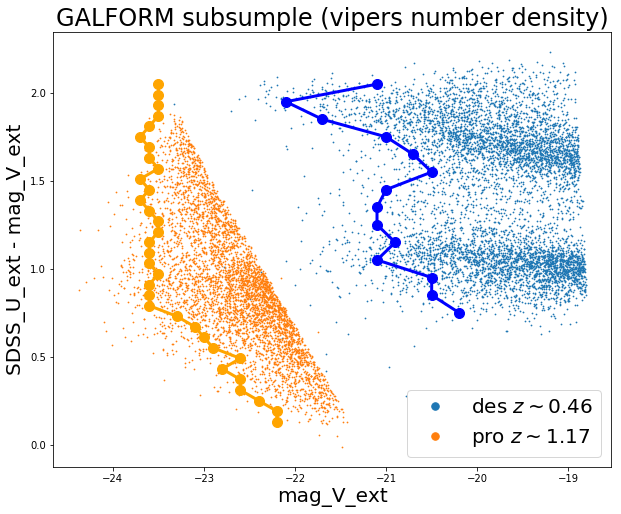

In [218]:
plt.figure(figsize=(10,8))
#data-points
plt.plot(xd[sub_samp_des],yd[sub_samp_des],".",markersize=1.5,label=r'des $z\sim0.46$',c='C0')
plt.plot(xp[sub_samp_pro],yp[sub_samp_pro],".",markersize=1.5,label=r'pro $z\sim1.17$',c='C1')
#edges
plt.plot(xp_edge_sub,yp_edge_sub,".",markersize=20,c='orange')
plt.plot(xp_edge_sub,yp_edge_sub,"-",lw=3,c='orange')
plt.plot(xd_edge_sub,yd_edge_sub,".",markersize=20,c='blue')
plt.plot(xd_edge_sub,yd_edge_sub,"-",lw=3,c='blue')
#labels
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=10)
plt.title("GALFORM subsumple (vipers number density)")
plt.savefig("../plots/009/col_mag_des_prog_cut225_subsample.png")
plt.show()

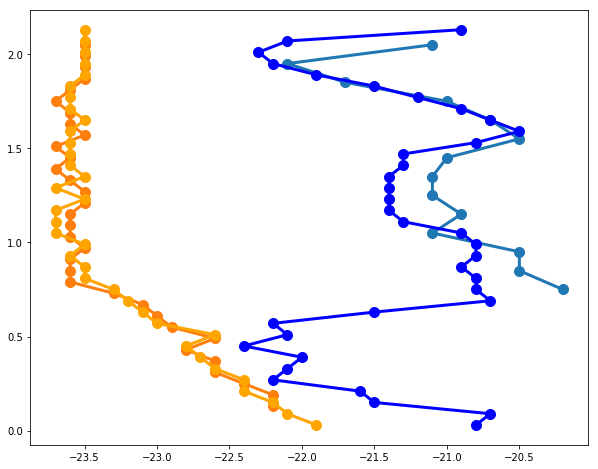

In [222]:
plt.figure(figsize=(10,8))

plt.plot(xp_edge_sub,yp_edge_sub,".",markersize=20,c='C1')
plt.plot(xp_edge_sub,yp_edge_sub,"-",lw=3,c='C1')
plt.plot(xd_edge_sub,yd_edge_sub,".",markersize=20,c='C0')
plt.plot(xd_edge_sub,yd_edge_sub,"-",lw=3,c='C0')

plt.plot(xp_edge,yp_edge,".",markersize=20,c='orange')
plt.plot(xp_edge,yp_edge,"-",lw=3,c='orange')
plt.plot(xd_edge,yd_edge,".",markersize=20,c='blue')
plt.plot(xd_edge,yd_edge,"-",lw=3,c='blue')

In [252]:
2+2

4